# **Comparing performance of models using synthetic data**
This notebook is used to test the performance of baseline models by applying synthetic data generated from CTGAN model

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.neural_network import MLPClassifier


import warnings
warnings.filterwarnings("ignore")

In [66]:
data = pd.read_csv('/home/nhat/projectcuoiky/data/pdf_features.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11101 entries, 0 to 11100
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Page           11101 non-null  int64  
 1   Encrypt        11101 non-null  int64  
 2   ObjStm         11101 non-null  int64  
 3   JS             11101 non-null  int64  
 4   JavaScript     11101 non-null  int64  
 5   AA             11101 non-null  int64  
 6   OpenAction     11101 non-null  int64  
 7   AcroForm       11101 non-null  int64  
 8   JBIG2Decode    11101 non-null  int64  
 9   RichMedia      11101 non-null  int64  
 10  Launch         11101 non-null  int64  
 11  EmbeddedFile   11101 non-null  int64  
 12  XFA            11101 non-null  int64  
 13  Colors_gt_224  11101 non-null  int64  
 14  obj            11101 non-null  int64  
 15  endobj         11101 non-null  int64  
 16  stream         11101 non-null  int64  
 17  endstream      11101 non-null  int64  
 18  xref  

,Page,Encrypt,ObjStm,JS,JavaScript,AA,OpenAction,AcroForm,JBIG2Decode,RichMedia,...,endobj,stream,endstream,xref,trailer,startxref,filepath,filename,filesize_kb,label
0,1,0,0,0,0,0,0,0,0,0,...,11,3,3,2,2,2,/home/remnux/Desktop/extraction/data/Benign/as...,assehc.pdf,23.120117,benign
1,1,0,0,0,0,0,0,0,0,0,...,6,2,2,1,1,1,/home/remnux/Desktop/extraction/data/Benign/ar...,artauthor.pdf,69.544922,benign
2,4,0,6,0,0,0,0,0,0,0,...,56,41,41,0,0,3,/home/remnux/Desktop/extraction/data/Benign/p4...,p4894_ru.pdf,180.786133,benign
3,1,0,0,0,0,0,0,1,0,0,...,29,17,17,2,2,2,/home/remnux/Desktop/extraction/data/Benign/ar...,artisticwall.pdf,85.124023,benign
4,6,0,25,0,0,0,0,2,0,0,...,156,146,146,0,0,4,/home/remnux/Desktop/extraction/data/Benign/f9...,f990sn.pdf,126.099609,benign


In [67]:
import pandas as pd
import numpy as np

# --- Configuration ---
SYNTHETIC_DATA_PATH = '/home/nhat/projectcuoiky/output/new_synthetic_malicious_data_8000_samples.csv'
ORIGINAL_TARGET_COL = 'label' # The target column name in the original data (after any initial renaming)
SYNTHETIC_TARGET_COL_RAW = 'label' # The raw target column name in the synthetic CSV 
FINAL_TARGET_COL = 'label'      # The consistent target column name to be used after processing both datasets

print("--- Augmenting Data with CTGAN Synthetic Samples ---")

# --- 1. Load Original Data (variable 'data' should exist from the previous cell) ---
print("\n--- Original Data (from previous cell) ---")
if 'data' in locals() or 'data' in globals():
    print(f"Shape of original data: {data.shape}")
    print(f"Original data columns: {data.columns.tolist()}")
    # If original data has a different target column name initially, rename it to FINAL_TARGET_COL
    if ORIGINAL_TARGET_COL != FINAL_TARGET_COL and ORIGINAL_TARGET_COL in data.columns:
        print(f"Renaming original data target column '{ORIGINAL_TARGET_COL}' to '{FINAL_TARGET_COL}'")
        data.rename(columns={ORIGINAL_TARGET_COL: FINAL_TARGET_COL}, inplace=True)
    elif ORIGINAL_TARGET_COL not in data.columns and FINAL_TARGET_COL not in data.columns:
        print(f"ERROR: Neither '{ORIGINAL_TARGET_COL}' nor '{FINAL_TARGET_COL}' found in original data. Please check column names.")
        # Potentially raise an error or handle this state
else:
    print("ERROR: Original data DataFrame 'data' not found. Please ensure it's loaded in the preceding cell.")
    # Potentially raise an error

# --- 2. Load Synthetic Data ---
print("\n--- Synthetic Data ---")
try:
    synthetic_df = pd.read_csv(SYNTHETIC_DATA_PATH)
    print(f"Synthetic data loaded successfully from: {SYNTHETIC_DATA_PATH}")
    print(f"Shape of synthetic data: {synthetic_df.shape}")
    print(f"Synthetic data columns: {synthetic_df.columns.tolist()}")

    # --- 3. Prepare Synthetic Data Target Column ---
    if SYNTHETIC_TARGET_COL_RAW in synthetic_df.columns:
        if SYNTHETIC_TARGET_COL_RAW != FINAL_TARGET_COL:
            print(f"Renaming synthetic data target column '{SYNTHETIC_TARGET_COL_RAW}' to '{FINAL_TARGET_COL}'")
            synthetic_df.rename(columns={SYNTHETIC_TARGET_COL_RAW: FINAL_TARGET_COL}, inplace=True)
        # Ensure the target column is of a compatible type if it needs to be (e.g., if it was numeric and original is string before LE)
        # For now, we assume it's ready for concatenation or will be handled by LabelEncoder later.
    else:
        print(f"ERROR: Raw target column '{SYNTHETIC_TARGET_COL_RAW}' not found in synthetic data.")
        # Handle error: maybe skip augmentation or raise error

    # --- 4. Align Columns (Crucial Step) ---
    # Ensure both DataFrames have the same columns in the same order before concatenation.
    # We'll use the original data's columns as the reference, excluding any columns in synthetic that aren't in original.
    if 'data' in locals() or 'data' in globals():
        original_cols = data.columns
        synthetic_df = synthetic_df[original_cols.intersection(synthetic_df.columns)] # Keep only common columns
        
        # Reorder synthetic_df columns to match original_df, and add missing columns with NaN if any
        # (though intersection should prevent needing to add NaNs for missing feature columns from original)
        synthetic_df = synthetic_df.reindex(columns=original_cols)

        print(f"Synthetic data columns after alignment: {synthetic_df.columns.tolist()}")

        # --- 5. Concatenate Data ---
        # The original 'data' DataFrame is now updated to be the augmented version
        data = pd.concat([data, synthetic_df], ignore_index=True)
        print("\n--- Data Augmentation Complete ---")
        print(f"Shape of combined (augmented) data: {data.shape}")
        print(f"'{FINAL_TARGET_COL}' column in combined data:\n{data[FINAL_TARGET_COL].value_counts(dropna=False)}")
    else:
        print("Skipping column alignment and concatenation as original 'data' is not available.")

except FileNotFoundError:
    print(f"ERROR: Synthetic data file not found at {SYNTHETIC_DATA_PATH}. Proceeding with original data only.")
    # No change to 'data' DataFrame in this case
except Exception as e:
    print(f"An error occurred during synthetic data loading or processing: {e}")
    print("Proceeding with original data only.")
    # No change to 'data' DataFrame in this case

# Display info of the potentially augmented 'data' DataFrame
print("\n--- Info for 'data' DataFrame (potentially augmented) ---")
if 'data' in locals() or 'data' in globals():
    data.info()
    print(data.head())
else:
    print("DataFrame 'data' is not defined.")

--- Augmenting Data with CTGAN Synthetic Samples ---

--- Original Data (from previous cell) ---
Shape of original data: (11101, 25)
Original data columns: ['Page', 'Encrypt', 'ObjStm', 'JS', 'JavaScript', 'AA', 'OpenAction', 'AcroForm', 'JBIG2Decode', 'RichMedia', 'Launch', 'EmbeddedFile', 'XFA', 'Colors_gt_224', 'obj', 'endobj', 'stream', 'endstream', 'xref', 'trailer', 'startxref', 'filepath', 'filename', 'filesize_kb', 'label']

--- Synthetic Data ---
Synthetic data loaded successfully from: /home/nhat/projectcuoiky/output/new_synthetic_malicious_data_8000_samples.csv
Shape of synthetic data: (8000, 22)
Synthetic data columns: ['Page', 'Encrypt', 'ObjStm', 'JS', 'JavaScript', 'AA', 'OpenAction', 'AcroForm', 'JBIG2Decode', 'RichMedia', 'Launch', 'EmbeddedFile', 'XFA', 'Colors_gt_224', 'obj', 'stream', 'xref', 'trailer', 'startxref', 'filesize_kb', 'label_numeric', 'label']
Synthetic data columns after alignment: ['Page', 'Encrypt', 'ObjStm', 'JS', 'JavaScript', 'AA', 'OpenAction', '

In [68]:
# Label Encoding
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Encode labels
le = LabelEncoder()
data["label_encoded"] = le.fit_transform(data["label"])

# Drop non-numeric columns first
X = data.drop(columns=['label', 'label_encoded', 'filepath', 'filename'])
y = data['label_encoded']

# Handle NaN values using SimpleImputer
print("Checking for NaN values in the dataset...")
print(f"Number of NaN values: {X.isna().sum().sum()}")

# Apply imputation to handle NaN values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
print("NaN values have been imputed with mean strategy")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Checking for NaN values in the dataset...
Number of NaN values: 16000
NaN values have been imputed with mean strategy
X_train shape: (15280, 22)
X_test shape: (3821, 22)
y_train shape: (15280,)
y_test shape: (3821,)


### Training Models

In [69]:
# Define models (Identical to original notebook)
models = {
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42, algorithm='SAMME'), # algorithm='SAMME' for discrete targets
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42, verbosity=-1),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "MLP Classifier": MLPClassifier(random_state=42, max_iter=500)
}

# Store results (Identical to original notebook)
results = {}

In [70]:
%%time

# Train and evaluate each model (Identical to original notebook training loop)
# This loop will use X_train, y_train, X_test, y_test which are now based on augmented data.
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for ROC AUC
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    # Ensure target_names are appropriate if the classes are not just 0 and 1 after label encoding
    # For simplicity, assuming binary classification with labels 0, 1 for report
    class_report_dict = classification_report(y_test, y_pred, output_dict=True)
    class_report_str = classification_report(y_test, y_pred)
    roc_auc_val = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        "Accuracy": accuracy,
        "Confusion Matrix": cm,
        "Classification Report Dict": class_report_dict,
        "Classification Report Str": class_report_str,
        "ROC AUC": roc_auc_val,
        "y_pred_proba": y_pred_proba # Store for plotting ROC curve later
    }
    
    print(f"Results for {name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  ROC AUC: {roc_auc_val:.4f}")
    print(f"  Confusion Matrix:\n{cm}")
    print(f"  Classification Report:\n{class_report_str}")
    print("-----------------------------------------------------")

# Example of how to access specific parts of the report if needed later:
print(results['Logistic Regression']['Classification Report Dict']['1']['precision'])


Results for Logistic Regression:
  Accuracy: 0.9183
  ROC AUC: 0.9681
  Confusion Matrix:
[[1701  121]
 [ 191 1808]]
  Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1822
           1       0.94      0.90      0.92      1999

    accuracy                           0.92      3821
   macro avg       0.92      0.92      0.92      3821
weighted avg       0.92      0.92      0.92      3821

-----------------------------------------------------
Results for Decision Tree:
  Accuracy: 0.9893
  ROC AUC: 0.9894
  Confusion Matrix:
[[1809   13]
 [  28 1971]]
  Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1822
           1       0.99      0.99      0.99      1999

    accuracy                           0.99      3821
   macro avg       0.99      0.99      0.99      3821
weighted avg       0.99      0.99      0.99      3821

--------------

### Compare Models

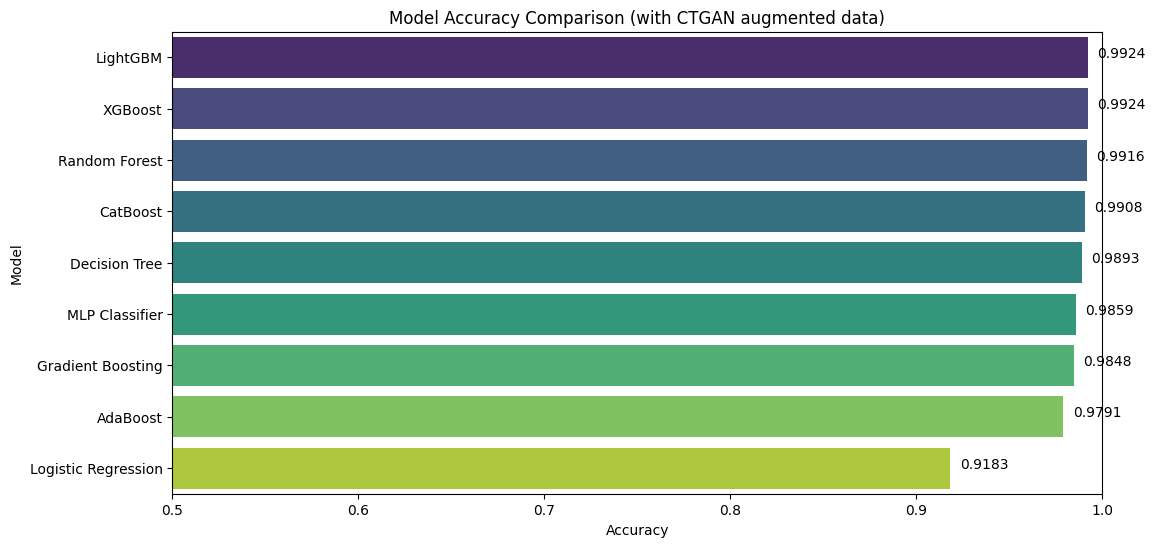

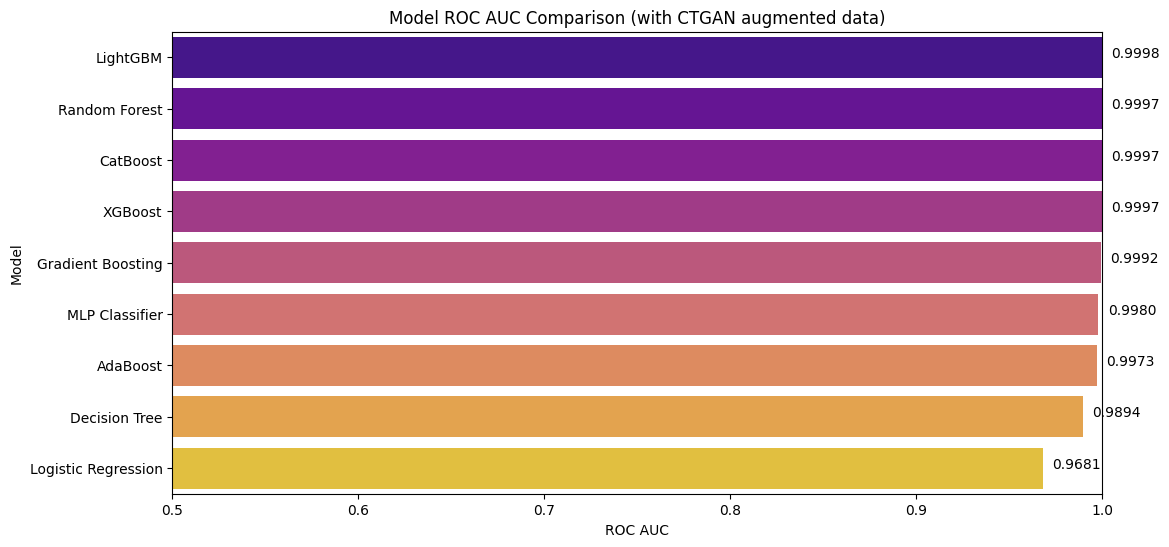


--- Detailed Classification Reports (with CTGAN augmented data) ---

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1822
           1       0.94      0.90      0.92      1999

    accuracy                           0.92      3821
   macro avg       0.92      0.92      0.92      3821
weighted avg       0.92      0.92      0.92      3821

-----------------------------------------------------

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1822
           1       0.99      0.99      0.99      1999

    accuracy                           0.99      3821
   macro avg       0.99      0.99      0.99      3821
weighted avg       0.99      0.99      0.99      3821

-----------------------------------------------------

Classification Report for Random Forest:
              precision    recall  f1

In [71]:
# Prepare data for plotting (Identical to original notebook)
accuracy_scores = {name: res["Accuracy"] for name, res in results.items()}
roc_auc_scores = {name: res["ROC AUC"] for name, res in results.items()}

# Create a DataFrame for easy plotting
plot_df_accuracy = pd.DataFrame(list(accuracy_scores.items()), columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=False)
plot_df_roc_auc = pd.DataFrame(list(roc_auc_scores.items()), columns=["Model", "ROC AUC"]).sort_values(by="ROC AUC", ascending=False)

# Plot Accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x="Accuracy", y="Model", data=plot_df_accuracy, palette="viridis")
plt.title("Model Accuracy Comparison (with CTGAN augmented data)") # Title updated
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(min(0.5, plot_df_accuracy["Accuracy"].min() * 0.9 if not plot_df_accuracy.empty else 0.5), 1.0) # Dynamic xlim
for index, value in enumerate(plot_df_accuracy["Accuracy"]):
    plt.text(value + 0.005, index, f'{value:.4f}') # Adjusted text position
plt.show()

# Plot ROC AUC
plt.figure(figsize=(12, 6))
sns.barplot(x="ROC AUC", y="Model", data=plot_df_roc_auc, palette="plasma") # Changed palette for variety
plt.title("Model ROC AUC Comparison (with CTGAN augmented data)") # Title updated
plt.xlabel("ROC AUC")
plt.ylabel("Model")
plt.xlim(min(0.5, plot_df_roc_auc["ROC AUC"].min() * 0.9 if not plot_df_roc_auc.empty else 0.5), 1.0) # Dynamic xlim
for index, value in enumerate(plot_df_roc_auc["ROC AUC"]):
    plt.text(value + 0.005, index, f'{value:.4f}') # Adjusted text position
plt.show()

# Print Classification Reports from the stored dictionary
print("\n--- Detailed Classification Reports (with CTGAN augmented data) ---")
for name, res in results.items():
    print(f"\nClassification Report for {name}:")
    # Make sure the string report was stored, or re-generate if only dict was stored
    if "Classification Report Str" in res:
        print(res["Classification Report Str"])
    elif "Classification Report Dict" in res:
        # If only dict is available, print it (it might be less readable directly)
        # Or reconstruct a string version. For now, just printing dict as fallback.
        print(pd.DataFrame(res["Classification Report Dict"]).transpose())
    else:
        print("Report not available.")
    print("-----------------------------------------------------")

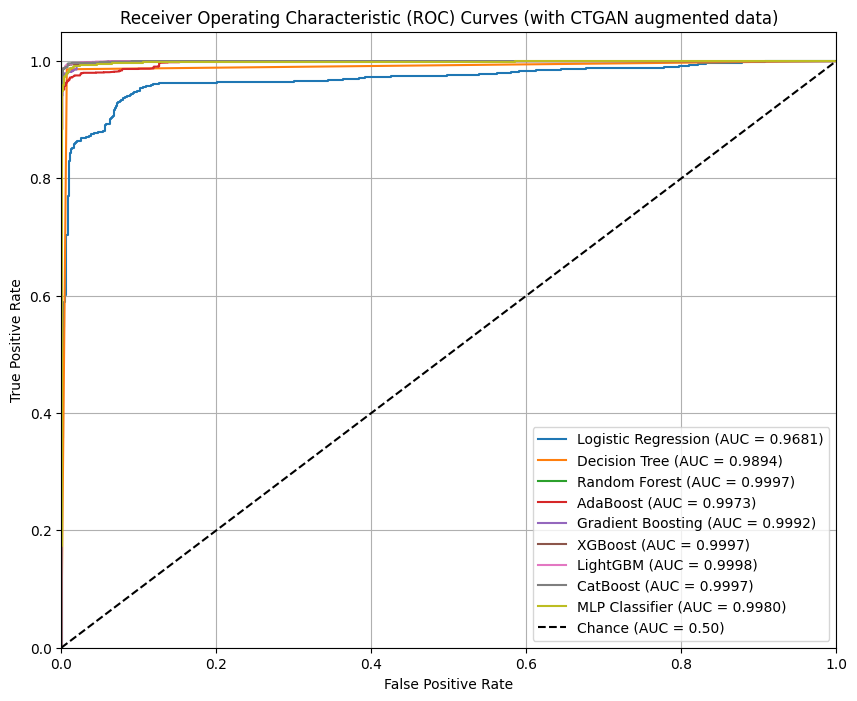

In [72]:
# Plot ROC curves for all models (Identical to original notebook)
plt.figure(figsize=(10, 8))

for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_pred_proba"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)') # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves (with CTGAN augmented data)') # Title updated
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

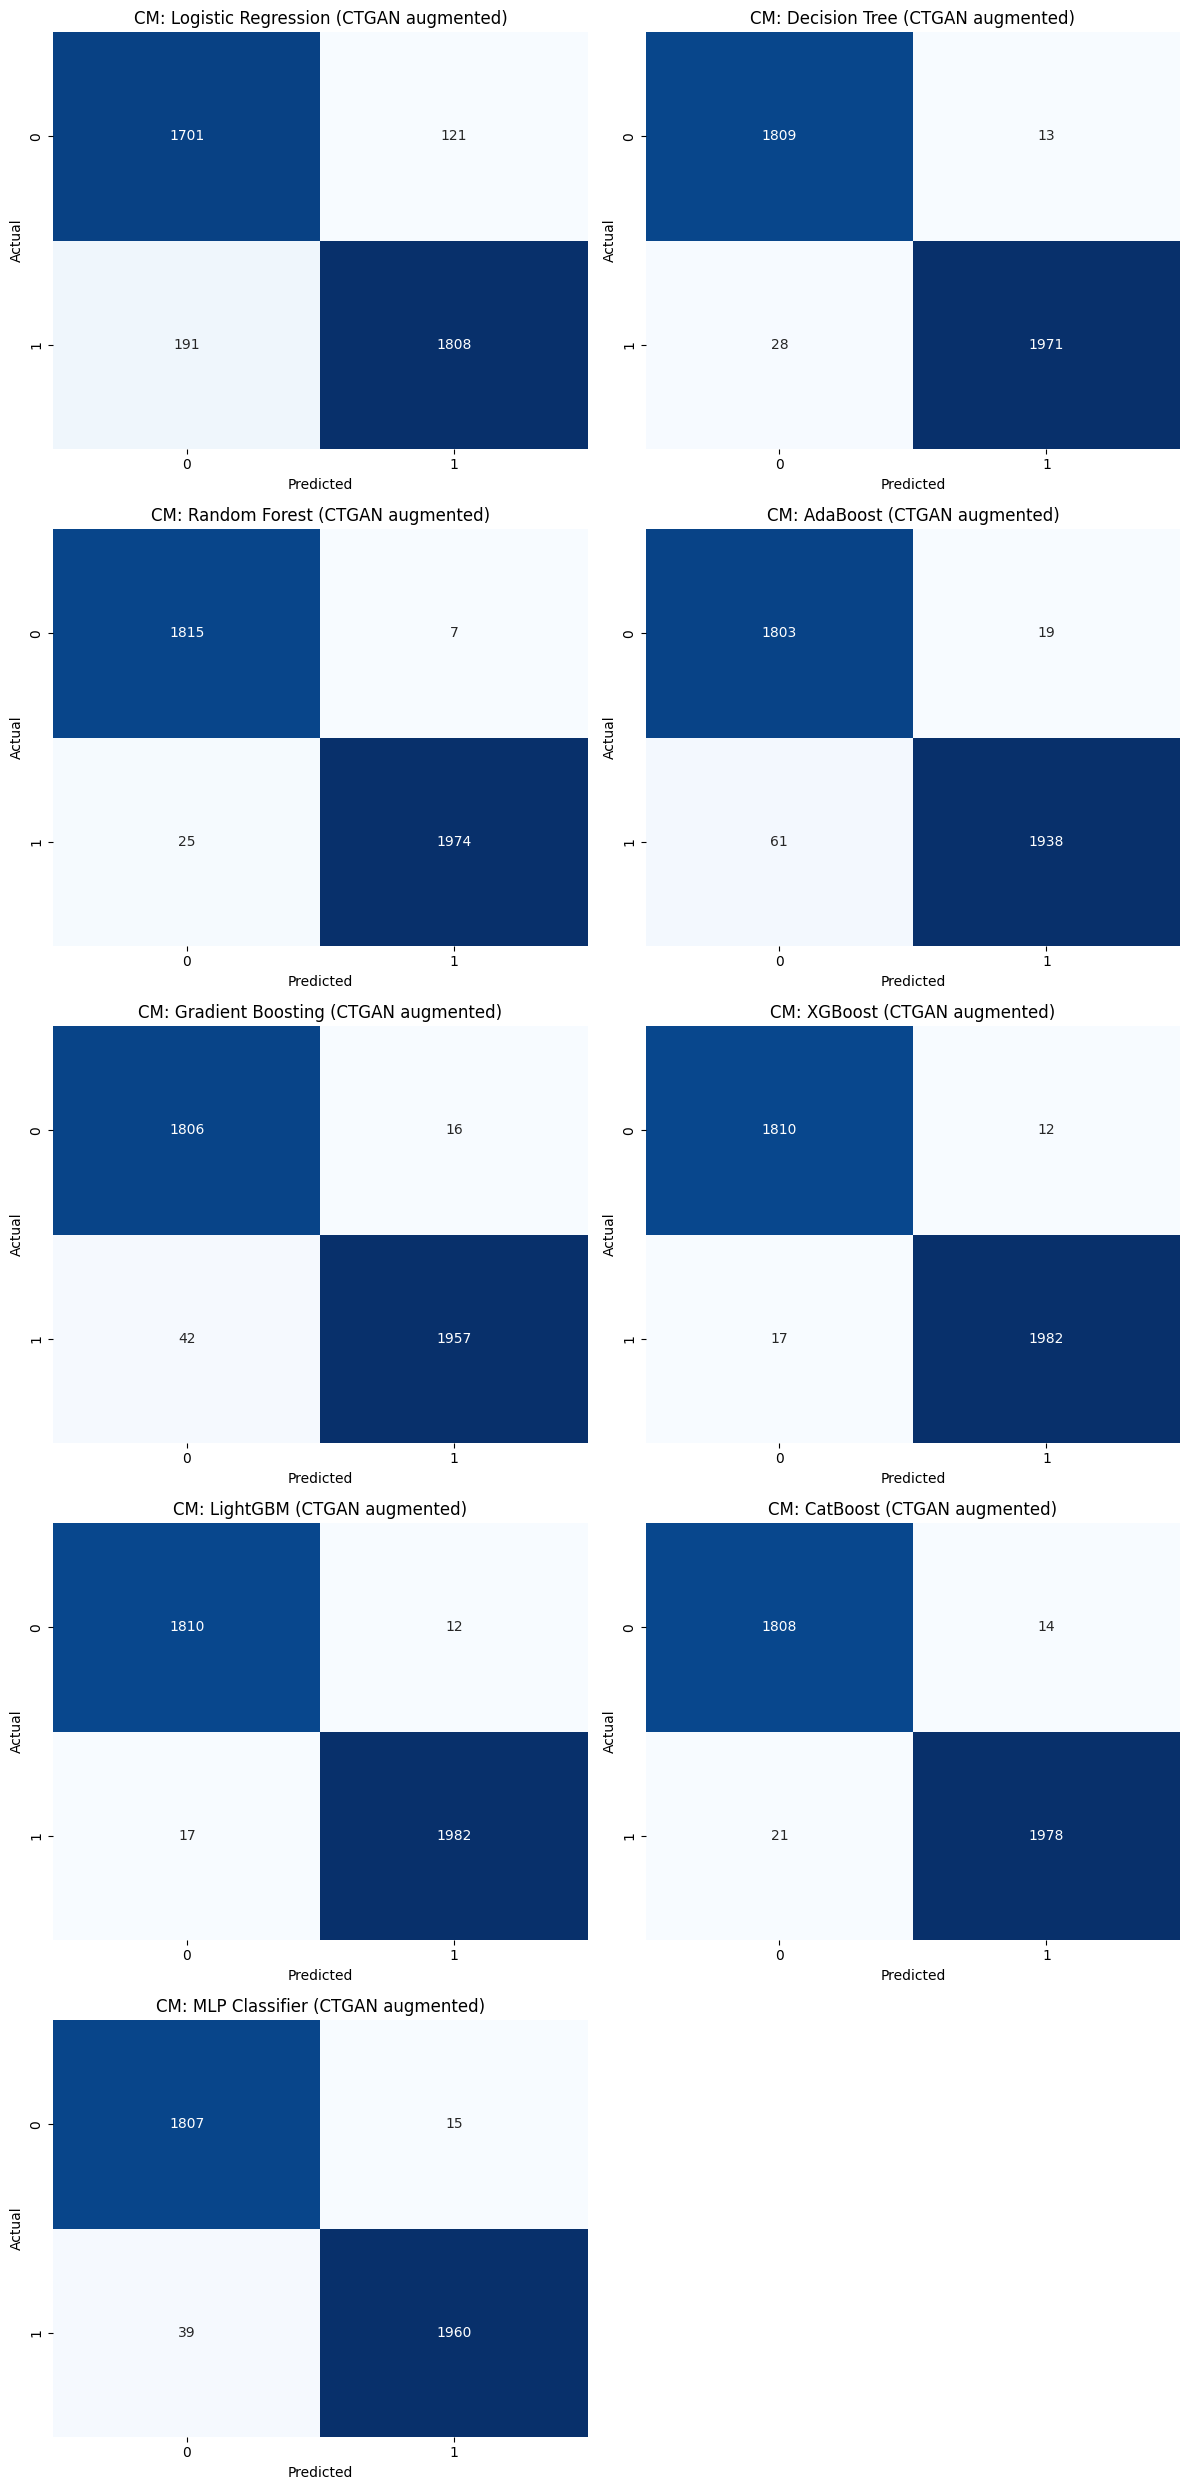

In [74]:
# Display confusion matrices for all models (Identical to original notebook)

num_models = len(models)
# Adjust subplot grid dynamically based on number of models
cols = 2  # Number of columns for subplots
rows = (num_models + cols - 1) // cols # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows), squeeze=False) # Ensure axes is always 2D
axes = axes.flatten() # Flatten to 1D array for easy iteration

for i, (name, res) in enumerate(results.items()):
    if i < len(axes): # Ensure we don't try to plot on a non-existent axis
        cm = res["Confusion Matrix"]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f'CM: {name} (CTGAN augmented)') # Title updated
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    else:
        print(f"Warning: Not enough subplots to display confusion matrix for {name}")

# Hide any unused subplots if the number of models is not a multiple of cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()